In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvx_portfolio as cp

plotdir = '../portfolio/plots/'

## Download data using ee103 code (to be integrated) 

In [2]:
datadir= '../equity_data_tool/'
sigmas=pd.read_csv(datadir+'sigmas.txt',index_col=0,parse_dates=[0])
returns=pd.read_csv(datadir+'returns.txt',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.txt',index_col=0,parse_dates=[0])

a = pd.DataFrame(data=2.5*1e-4, index=volumes.index, columns=volumes.columns)
b = pd.DataFrame(data=1, index=volumes.index, columns=volumes.columns) # fix volatility model
s = pd.DataFrame(data=1*1e-4, index=volumes.index, columns=volumes.columns)

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

start_t="2012-01-01"
end_t="2016-12-31"

np.random.seed(0)
noise=pd.DataFrame(index=returns.index, columns=returns.columns, 
                   data=0.1*np.random.randn(*returns.values.shape))
return_estimate= returns + noise
return_estimate.USDOLLAR = returns.USDOLLAR
alpha_model = cp.AlphaSource(return_estimate)

In [6]:
simulated_tcost = cp.TcostModel(volumes, sigmas, a, b, cash_key='USDOLLAR')
simulated_hcost = cp.HcostModel(s, cash_key='USDOLLAR')
simulator = cp.MarketSimulator(returns, volumes, [simulated_tcost, simulated_hcost], cash_key='USDOLLAR')

In [20]:
from cvx_portfolio.data import series_factor_model_covariance
exposures_pan, factor_sigma_pan, idyos_df = series_factor_model_covariance(returns, variance_explained=.75,
                                                                           freq='MS',lookback_periods = 12)
risk_model = cp.FactorModelSigma(exposures_pan, factor_sigma_pan, idyos_df)


gamma_tcost=100.
policies={}
for lev in [1, 2, 3]:
    for risk in [.5,10,100, 1000] : 
        policies[(risk, lev)] = \
                cp.SinglePeriodOpt(alpha_model, [risk*risk_model, gamma_tcost*simulated_tcost], 
                                [cp.LeverageLimit(lev)])

## Simulations

In [21]:
results=dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,end_time=end_t,
                                              policies=policies.values(), parallel=True)))

In [29]:
result_df=pd.DataFrame()
for k in results:
    result_df.loc[k[0], float(k[1])]= results[k]
result_df.index.name = 'gamma_risk'
result_df.columns.name = 'leverage'
result_df = result_df.reindex(index=sorted(result_df.index),columns=sorted(result_df.columns))

In [30]:
# result_df=result_df.loc[result_df.index[:3]]
# result_df=result_df[[1,2,3]]

In [43]:
used_returns = returns.loc[(returns.index>=start_t)&(returns.index<=end_t)]
benchmark_returns = pd.Series(index=used_returns.index, data=used_returns.USDOLLAR)

result_df_used= result_df

table=pd.DataFrame()
table[r'Excess return']=\
result_df_used.applymap(lambda res: 100*250*(res.returns - benchmark_returns).mean()).unstack()
table[r'Transaction costs']=\
    result_df_used.applymap(lambda res: (res.simulator_TcostModel.sum(1)/res.v).mean() * 100 * 250).unstack()
table[r'Excess risk']= \
    result_df_used.applymap(lambda res: np.std(benchmark_returns - res.returns)*100*np.sqrt(250)).unstack()
    
# avg_daily_return=lambda res: "%.2f%%"%(res.mean_return*100)
# avg_annual_tcost=lambda res: "%.2f%%"%((res.simulator_TcostModel.sum(1)/res.v).mean() *250*100)
# volatility=lambda res: "%.2f%%"%(res.volatility*100)

# table=pd.Panel({r'Return':result_df_used.applymap(avg_daily_return),
#           r'Trans. costs':result_df_used.applymap(avg_annual_tcost),
#           r'Volatility':result_df_used.applymap(volatility),
#                }).to_frame()
table = table.set_index(table.index.rename([ r'$L^\mathrm{max}$',r'$\gamma^\mathrm{risk}$',]))

# format index
table=table.set_index(table.index.set_levels([["%g"%i for i in table.index.levels[0]],
                      ["%g"%i for i in table.index.levels[1]]]))

table_print=pd.DataFrame(table,copy=True)
table_print.ix[:,:]=table_print.ix[:,:].applymap(lambda x: r'%.2f%%'%x )
print(table_print.to_latex(float_format='%.2f', escape=False).replace('%',r'\%'))

\begin{tabular}{lllll}
\toprule
  &     & Excess return & Transaction costs & Excess risk \\
$L^\mathrm{max}$ & $\gamma^\mathrm{risk}$ &               &                   &             \\
\midrule
1 & 0.5 &        19.63\% &            24.55\% &      20.12\% \\
  & 10 &        19.65\% &            24.55\% &      19.39\% \\
  & 100 &        19.30\% &            23.33\% &      15.51\% \\
  & 1000 &        12.16\% &            12.51\% &       6.48\% \\
2 & 0.5 &        20.92\% &            44.76\% &      26.54\% \\
  & 10 &        19.85\% &            45.02\% &      24.98\% \\
  & 100 &        17.84\% &            44.13\% &      16.31\% \\
  & 1000 &        12.35\% &            33.03\% &       7.26\% \\
3 & 0.5 &        21.66\% &            58.92\% &      33.84\% \\
  & 10 &        19.44\% &            59.33\% &      31.07\% \\
  & 100 &        16.95\% &            56.37\% &      18.12\% \\
  & 1000 &        10.74\% &            44.54\% &       8.87\% \\
\bottomrule
\end{tabular}



In [32]:
print(table.to_latex(escape=False).replace('%','\%'))

\begin{tabular}{llrrr}
\toprule
  &     &  Excess return &  Transaction costs &  Excess risk \\
$\gamma^\mathrm{risk}$ & $L^\mathrm{max}$ &                &                    &              \\
\midrule
1 & 0.5 &      19.632144 &          24.553414 &    20.122533 \\
  & 10 &      19.646258 &          24.551280 &    19.392819 \\
  & 100 &      19.299742 &          23.331196 &    15.505528 \\
  & 1000 &      12.159072 &          12.511250 &     6.477305 \\
2 & 0.5 &      20.920115 &          44.761345 &    26.537791 \\
  & 10 &      19.849978 &          45.020499 &    24.975997 \\
  & 100 &      17.842867 &          44.129998 &    16.312074 \\
  & 1000 &      12.351442 &          33.031294 &     7.257551 \\
3 & 0.5 &      21.663801 &          58.923779 &    33.835210 \\
  & 10 &      19.444125 &          59.332663 &    31.069749 \\
  & 100 &      16.954242 &          56.374445 &    18.120456 \\
  & 1000 &      10.740283 &          44.537825 &     8.871789 \\
\bottomrule
\end{tabular}



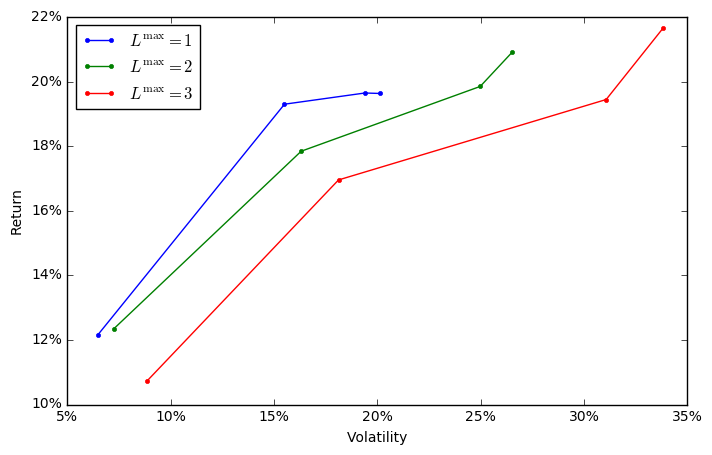

In [41]:
# plt.figure(figsize=(8,5))
# for leverage in result_df.columns:
#     x = [100*result_df.loc[(i, leverage)].volatility for i in result_df.index]
#     y = [100*result_df.loc[(i, leverage)].mean_return for i in result_df.index]
#     plt.plot(np.array(x),np.array(y), '.-', label=r'$L^\mathrm{max} = %g$'%leverage)
# plt.legend(loc='upper left')
# plt.xlabel('Volatility')
# plt.ylabel('Return')

plt.figure(figsize=(8,5))
for leverage in table.index.levels[0][:]:
    x = table.loc[leverage]['Excess risk']
    y = table.loc[leverage]['Excess return']
    plt.plot(np.array(x),np.array(y), '.-', label=r'$L^\mathrm{max} = %s$'%leverage)
plt.legend(loc='upper left')
plt.xlabel('Volatility')
plt.ylabel('Return')


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%g%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%g%%'))

plt.savefig(plotdir+'constr_riskrewardfrontier.png')

In [ ]:
# x = [results_s.loc[l].volatility*100 for l in results_s.index]
# y = [results_s.loc[l].mean_return*100 for l in results_s.index]
# plt.plot(np.array(x),np.array(y), '.-')

In [ ]:
# for i in range(5):\
#     results_s.values[i].leverage.plot(label='%g'%leverages[i])
# plt.legend()

In [ ]:
# for i in range(5):\
#     results_s.values[i].v.plot(label='%g'%leverages[i])
# plt.legend()

In [ ]:
# for i in range(5):\
#     results_s.values[i].w['USDOLLAR'].plot(label='%g'%leverages[i])
# plt.legend()

In [ ]:
# for i in range(5):\
#     (np.sqrt(250)*np.sqrt(results_s.values[i].policy_FactorModelSigma)).plot(label='%g'%leverages[i])
# plt.legend()